## **Sadece Yapay Sinir Ağı Kullanarak Balık Sınıflandırma**

**Yapay sinir ağları birçok sınıflandırma problemleri için kullanılabilir. Bu projemizde ise Akbank Derin Öğrenme Bootcamp'i doğrultusunda herhangi bir evrişimsel model kullanmadan doğrudan saf kendi oluşturacağımız bir sinir ağı ile Balıklarımızın türlerini tahmin edeceğiz. 😉**

**1. VERİ KÜMESİNİ OKUMA:** Öncelikle balıklarımızın bulunduğu veri kümesini okuyacağız. Bu veri kümesinde ihtiyacımızın olmadığı, isminde "GT" geçen görüntüler var bunları kaldıracağız.

**2. VERİYİ KEŞFETMEK:** Veri kümemizi inceleyeceğiz, balıklarımızın türlerini, görüntülerini ve miktarlarını göreceğiz.

**3. VERİYİ İŞLEMEK:** Veri kümemizdeki görüntüleri işleyeceğiz, oluşturacağımız modele uygun bir hale getireceğiz.

**4. VERİYİ AYIRMAK:** Veri kümemizi eğitim, validasyon ve test olmak üzere 3 gruba ayıracağız.

**5. MODELİ OLUŞTURMAK:** Modelimizi katman katman oluşturacağız.

**6. MODELİN EĞİTİLMESİ:** Ve modelimizi veri kümemiz ile eğiteceğiz.

**7. SONUÇLAR:** Son olarak modelimizin başarısını inceleyeceğiz.

## 1. VERİ KÜMESİNİ OKUMA 

İlk olarak tüm projemizde kullanacağımız python modüllerini bir arada çekirdeğimize ekliyoruz.

In [1]:
# Temel kütüphaneler
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io

# Görselleştirme
import seaborn as sn
from tqdm import tqdm

# Scikit-learn araçları
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow ve Keras ile ilgili kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras import optimizers
from tensorflow.keras.regularizers import l2

Veri kümemizi input kısmında ekledikten sonra veri kümemizi aşağıdaki hücrede gösterildiği gibi dosya konumunu belirterek okuyoruz.

In [2]:
root_dir  =  Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

filepaths = [str(path) for path in root_dir.glob("**/*.png") if "GT" not in str(path)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Class')

df = pd.DataFrame({'Filepath': filepaths, 'Class': labels})

## 2. VERİYİ KEŞFETMEK

In [3]:
df["Class"].unique()

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

### Veri Kümesindeki Balık Türleri

Veri kümemizde bulunan balık türlerini yukarıda gösterilen pandas'ın unique fonksiyonu ile ulaşabiliyoruz.

- Hourse Mackerel
- Black Sea Sprat
- Sea Bass
- Red Mullet
- Trout
- Striped Red Mullet
- Shrimp
- Gilt-Head Bream
- Red Sea Bream

## 3. VERİYİ İŞLEMEK

In [4]:
img_size = (256, 256)

def load_and_preprocess_image(filepath):
    
    img = load_img(filepath, target_size=img_size)  
    img_array = img_to_array(img)  
    return img_array

X = np.array([load_and_preprocess_image(fp) for fp in df['Filepath']])
y = np.array(df['Class'].tolist())  

Bu aşamada görüntüleri bir numpy dizisine dönüştürüp, görüntü dosyalarındaki renk bilgisini, sayılardan oluşan bir numpy dizisine aktarıyoruz. Bu şekilde modelin anlayabileceği hale getirmiş oluyoruz.

In [5]:
X[-1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [6]:
y[-1]

'Red Sea Bream'

## 4. VERİYİ AYIRMAK

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

Bu hücrede veri kümemizi %80 train, %10 validasyon ve %10 test bölümlerine ayırıyoruz.

In [8]:
X_train = X_train.reshape((X_train.shape[0], 256 * 256 * 3)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 256 * 256 * 3)).astype('float32') / 255
X_val = X_val.reshape((X_val.shape[0], 256 * 256 * 3)).astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7200, 196608)
(900, 196608)
(900, 196608)


In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_val_enc = le.transform(y_val)


y_train_cat = to_categorical(y_train_enc, num_classes=9)
y_test_cat = to_categorical(y_test_enc, num_classes=9)
y_val_cat = to_categorical(y_val_enc, num_classes=9)

In [10]:
print(y_train_cat[0])
print(y_test_cat[0])
print(y_val_cat[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 5. MODELİ OLUŞTURMAK

In [12]:
# Gelişmiş model oluşturma
model = Sequential([
    layers.Flatten(input_shape=(256 * 256 * 3,)),  # Görüntüleri düzleştirir
    layers.Dense(512, activation='relu'),     # İlk gizli katman
    layers.BatchNormalization(),               # Batch normalization
    layers.Dropout(0.5),                      # Dropout ile aşırı öğrenmeyi önle
    layers.Dense(256, activation='relu'),     # İkinci gizli katman
    layers.BatchNormalization(),               # Batch normalization
    layers.Dropout(0.5),                      # Dropout
    layers.Dense(128, activation='relu'),     # Üçüncü gizli katman
    layers.BatchNormalization(),               # Batch normalization
    layers.Dropout(0.5),                      # Dropout
    layers.Dense(9, activation='softmax')  # Çıkış katmanı
])

# Modeli derle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Burada 4 katmanlı ağımızı oluşturuyoruz. En son çıkış katmanımızda 9 kategori olduğu için 9 unit kullanıyoruz.

In [13]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=10, restore_best_weights=True)

## 6. MODELİN EĞİTİLMESİ

In [14]:
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_data=(X_val, y_val_cat),
    callbacks = early_stopping)

Epoch 1/30


I0000 00:00:1729799439.576246     107 service.cc:145] XLA service 0x7ff07c012240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729799439.576357     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/225 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1226 - loss: 3.5763

I0000 00:00:1729799445.793800     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2151 - loss: 2.7382 - val_accuracy: 0.3511 - val_loss: 2.0845
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3633 - loss: 1.8386 - val_accuracy: 0.6100 - val_loss: 1.1354
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4940 - loss: 1.4118 - val_accuracy: 0.6478 - val_loss: 0.9974
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5837 - loss: 1.1924 - val_accuracy: 0.5744 - val_loss: 1.1874
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6427 - loss: 1.0171 - val_accuracy: 0.6722 - val_loss: 0.9305
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6940 - loss: 0.8918 - val_accuracy: 0.7811 - val_loss: 0.6277
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7416 - loss: 0.7473 - val_accuracy: 0.7833 - val_loss: 0.6601
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7492 - loss: 0.7387 - val_accuracy: 0.60

## 7. SONUÇLAR

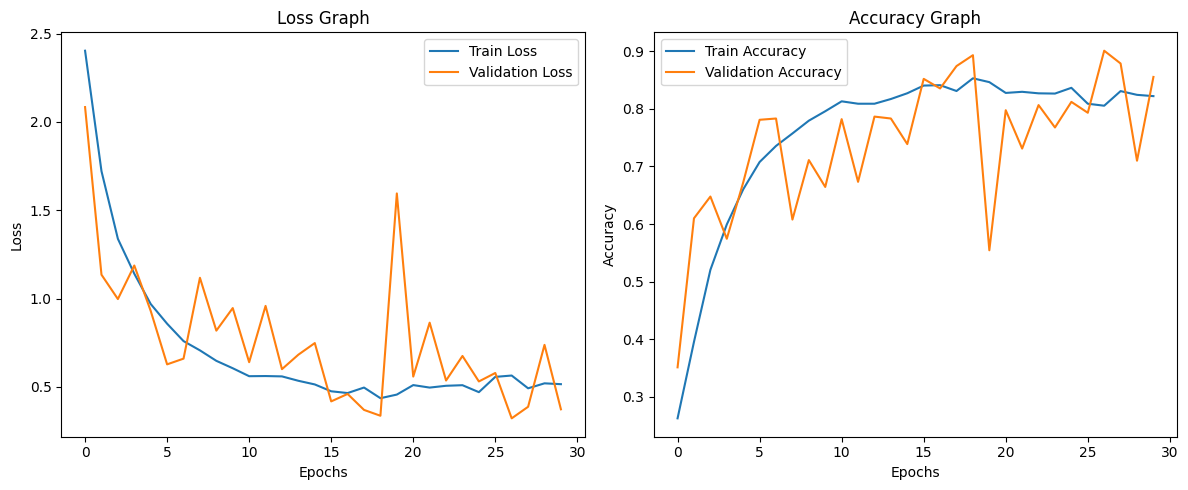

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.31089329719543457
Test Accuracy: 0.8966666460037231


| Metric         | Value       |
|----------------|-------------|
| **Test Loss**  | 0.3108      |
| **Test Accuracy** | 0.8966      |

Başarı metriklerini incelediğimizde modelimizin iyi bir başarı oranı olduğunu söyleyebiliriz. Hata oranı ise makul bir düzeyde. Daha iyi değerler elde edebilmek için veri arttırımı, hiperparametre optimizasyonu gibi yöntemler denenebilir.

### **TEŞEKKÜRLER, İYİ ÇALIŞMALAR DİLERİM!**